## Cleaning raw computer jobs dataset

In [2]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from datetime import date
from collections import Counter, OrderedDict
from statistics import mean
pd.options.mode.chained_assignment = None  # default='warn'

### Functions used in the project

In [3]:
#function for clearing strange ranges of values
def strange_range_func(x, l_range, h_range): 
    if x < l_range or x > h_range:
        return pd.NA
    else:
        return x
    
#function for clearing different unnecessary symbols
def strange_symbols_func(x, symbol_before, symbol_after): 
    if symbol_before in x:
        new_x = x.replace(symbol_before, symbol_after)
        return new_x
    else:
        return x
    
#function responsible for combining patterns
def combined_pattern_func(patterns_list):
    combined_pattern = "|".join(patterns_list) #version with capture groups combined_pattern = "(" + ")|(".join(patterns_list) + ")"
    return combined_pattern

### General clearing operations

In [10]:
#importing a raw dataset
df = pd.read_csv('uncleaned_computer_jobs_original.csv', encoding="latin-1")

#setting name as df index
df = df.set_index('index')

#renaming columns
df = df.rename(columns={"Job Title":"Job_Title",
                        "Salary Estimate":"Salary_Estimate_Thousands_of_USD",
                        "Job Description":"Job_Description",
                        "Company Name":"Company_Name",
                        "Founded":"Year_Founded",
                        "Size":"Number_of_Employees",
                        "Type of ownership":"Type_of_Ownership",
                        "Revenue":"Revenue_USD"})

#clearing rating column (rating on glassdoor site is from range 0 to 5)
df['Rating'] = df['Rating'].apply(strange_range_func, l_range = 0, h_range = 5)

#deleting second part of the company name, which is a rating after a new line symbol
n_line_comp_name_bmask = df['Company_Name'].str.contains('\n') #boolean array with a new line symbol
#splitting name at new line symbol and deleting last element 
df['Company_Name'].loc[n_line_comp_name_bmask] = df['Company_Name'].loc[n_line_comp_name_bmask].str.split('\n').str.get(0)

#clearing strange years of company foundation (1936 first computer was invented)

df['Year_Founded'] = df['Year_Founded'].apply(strange_range_func, l_range = 1936, h_range = date.today().year)

#changing '-1' industry, sector and competitors type as N/A
s_industry = df['Industry'] == '-1'
df['Industry'].loc[s_industry] = pd.NA
s_sector = df['Sector'] == '-1'
df['Sector'].loc[s_sector] = pd.NA
s_competitors = df['Competitors'] == '-1'
df['Competitors'].loc[s_competitors] = pd.NA

#clearing ownership types
t_ownership_1 = df['Type_of_Ownership'] == '-1'
df['Type_of_Ownership'].loc[t_ownership_1] = pd.NA
t_ownership_pp = df['Type_of_Ownership'] == 'Private Practice / Firm'
df['Type_of_Ownership'].loc[t_ownership_pp] = 'Company - Private'
t_ownership_u = df['Type_of_Ownership'] == 'Unknown'
df['Type_of_Ownership'].loc[t_ownership_u] = pd.NA
t_ownership_c = df['Type_of_Ownership'] == 'Contract'
df['Type_of_Ownership'].loc[t_ownership_c] = 'Self-employed'

#clearing revenue 
df['Revenue_USD'] = df['Revenue_USD'].apply(strange_symbols_func, symbol_before = '(USD)', symbol_after = "")
df['Revenue_USD'] = df['Revenue_USD'].apply(strange_symbols_func, symbol_before = '$', symbol_after = "")
df['Revenue_USD'] = df['Revenue_USD'].apply(strange_symbols_func, symbol_before = 'to', symbol_after = "-")
df['Revenue_USD'] = df['Revenue_USD'].apply(strange_symbols_func, symbol_before = ' ', symbol_after = "")
df['Revenue_USD'] = df['Revenue_USD'].apply(strange_symbols_func, symbol_before = 'million', symbol_after = '_000_000')
df['Revenue_USD'] = df['Revenue_USD'].apply(strange_symbols_func, symbol_before = 'billion', symbol_after = '_000_000_000')
revenue_unknown = df['Revenue_USD'] == 'Unknown/Non-Applicable'
df['Revenue_USD'].loc[revenue_unknown] = pd.NA
revenue_1 = df['Revenue_USD'] == '-1'
df['Revenue_USD'].loc[revenue_1] = pd.NA
revenue_less = df['Revenue_USD'] == 'Lessthan1_000_000'
df['Revenue_USD'].loc[revenue_less] = '1-1_000_000'
revenue_more = df['Revenue_USD'] == '10+_000_000_000'
df['Revenue_USD'].loc[revenue_more] = '10_000_000_000-<NA>'
df['Revenue_USD'] = df['Revenue_USD'].str.split('-')
df['Revenue_USD_Low'] = df['Revenue_USD'].str[0]
df['Revenue_USD_High'] = df['Revenue_USD'].str[-1]
revenue_unknown = df['Revenue_USD_High'] == '<NA>'
df['Revenue_USD_High'].loc[revenue_unknown] = pd.NA

#clearing number of employees
df['Number_of_Employees'] = df['Number_of_Employees'].apply(strange_symbols_func, symbol_before = ' to ', symbol_after = "-")
df['Number_of_Employees'] = df['Number_of_Employees'].apply(strange_symbols_func, symbol_before = ' employees', symbol_after = "")
employees_1 = df['Number_of_Employees'] == '-1'
df['Number_of_Employees'].loc[employees_1] = pd.NA
employees_unknown = df['Number_of_Employees'] == 'Unknown'
df['Number_of_Employees'].loc[employees_unknown] = pd.NA
df['Number_of_Employees'].loc[revenue_more] = '10000-<NA>'
df['Number_of_Employees'] = df['Number_of_Employees'].str.split('-')
df['Number_of_Employees_Low'] = df['Number_of_Employees'].str[0]
df['Number_of_Employees_High'] = df['Number_of_Employees'].str[-1]
employees_unknown = df['Number_of_Employees_High'] == '<NA>'
df['Number_of_Employees_High'].loc[employees_unknown] = pd.NA

#spliting headquarters location into city and state
headquarters_1 = df['Headquarters'] == '-1'
df['Headquarters'].loc[headquarters_1] = pd.NA
df['Headquarters'] = df['Headquarters'].str.split(',')
df['Headquarters_City'] = df['Headquarters'].str[0].str.title()
df['Headquarters_State/Country'] = df['Headquarters'].str[-1].str.strip()
headquarters_sc_061 = df['Headquarters_State/Country'] == '061'
df['Headquarters_State/Country'].loc[headquarters_sc_061] = pd.NA

#spliting location into city and state
location_1 = df['Location'] == '-1'
df['Location'].loc[location_1] = pd.NA
df['Location'] = df['Location'].str.split(',')
df['Location_City'] = df['Location'].str[0].str.title()
df['Location_State'] = df['Location'].str[-1].str.strip()
df['Location_State'].loc[df['Location_City'] == 'United States'] = pd.NA
df['Location_State'].loc[df['Location_City'] == 'Remote'] = pd.NA

#cleaning salary estimate
df['Salary_Estimate_Thousands_of_USD'] = df['Salary_Estimate_Thousands_of_USD'].str.findall(r'(\d+)')
df['Salary_Range_Low_Thousands_of_USD'] = df['Salary_Estimate_Thousands_of_USD'].str[0]
df['Salary_Range_High_Thousands_of_USD'] = df['Salary_Estimate_Thousands_of_USD'].str[1]

#looking for required skills and qualifications - proposed list: Python, Excel, Cloud systems (AWS, GCP), SQL, Tableu, PowerBI, ML, PHD
#they want a guy who knows excel
excel_pattern = r'excel'
excel_mask = df['Job_Description'].str.contains(excel_pattern, flags = re.I)
df['Excel_Skills'] = 0
df['Excel_Skills'].loc[excel_mask] = 1

#they want a guy who knows Python
python_patterns = ['Python', 'Pandas', 'Numpy', 'Scikit', 'scipy']
python_combined_pattern = combined_pattern_func(python_patterns)
python_mask = df['Job_Description'].str.contains(python_combined_pattern, flags = re.I)
df['Python_Skills'] = 0
df['Python_Skills'].loc[python_mask] = 1

#they want a guy who knows Cloud Systems like AWS or GPC
cloud_patterns = ['AWS', 'Amazon Web Server', 'GCP', 'Google Cloud Platform']
cloud_combined_pattern = combined_pattern_func(cloud_patterns)
cloud_mask = df['Job_Description'].str.contains(cloud_combined_pattern, flags = re.I)
df['Cloud_System_Skills'] = 0
df['Cloud_System_Skills'].loc[cloud_mask] = 1

#they want a guy who knows SQL
sql_patterns = ['SQL', 'Structured Query Language']
sql_combined_pattern = combined_pattern_func(sql_patterns)
sql_mask = df['Job_Description'].str.contains(sql_combined_pattern, flags = re.I)
df['SQL_Skills'] = 0
df['SQL_Skills'].loc[sql_mask] = 1

#they want a guy who knows Tableau or Power BI
tableau_power_BI_patterns = ['Tableau', 'power BI']
tableau_power_BI_combined_pattern = combined_pattern_func(tableau_power_BI_patterns)
tableau_power_BI_mask = df['Job_Description'].str.contains(tableau_power_BI_combined_pattern, flags = re.I)
df['Tableau_Power_BI_Skills'] = 0
df['Tableau_Power_BI_Skills'].loc[cloud_mask] = 1

#they want a guy who is familiar with Machine Learning
ml_patterns = ['ML', 'machine learning', 'DL', 'deep learning', 'Scikit-learn', 'AI', 'Artfical Intelligence']
ml_combined_pattern = combined_pattern_func(ml_patterns)
ml_mask = df['Job_Description'].str.contains(ml_combined_pattern, flags = re.I)
df['ML_Skills'] = 0
df['ML_Skills'].loc[ml_mask] = 1

#they want a guy who has PHD
phd_patterns = [r'\bPHD\b']
phd_combined_pattern = combined_pattern_func(phd_patterns)
phd_mask = df['Job_Description'].str.contains(phd_combined_pattern, flags = re.I)
df['PhD'] = 0
df['PhD'].loc[phd_mask] = 1

#obtaining a sum of required skills for 7 defined categories
df['Skills_Sum'] = df['Excel_Skills'] + df['Python_Skills'] + df['Cloud_System_Skills'] + df['SQL_Skills'] + df['Tableau_Power_BI_Skills'] + df['ML_Skills'] + df['PhD'] 

#dropping redundant columns
df = df.drop(['Headquarters', 'Number_of_Employees', 'Revenue_USD', 'Location', 'Salary_Estimate_Thousands_of_USD', 'Job_Description'], axis=1)
df.to_csv('cleaned_computer_jobs.csv') #exporting cleared file into csv
df.head()

,Job_Title,Rating,Company_Name,Year_Founded,Type_of_Ownership,Industry,Sector,Competitors,Revenue_USD_Low,Revenue_USD_High,...,Salary_Range_Low_Thousands_of_USD,Salary_Range_High_Thousands_of_USD,Excel_Skills,Python_Skills,Cloud_System_Skills,SQL_Skills,Tableau_Power_BI_Skills,ML_Skills,PhD,Skills_Sum
index,,,,,,,,,,,,,,,,,,,,,
0,Sr Data Scientist,3.1,Healthfirst,1993,Nonprofit Organization,Insurance Carriers,Insurance,"EmblemHealth, UnitedHealth Group, Aetna",<NA>,<NA>,...,137,171,0,0,1,0,1,1,0,3
1,Data Scientist,4.2,ManTech,1968,Company - Public,Research & Development,Business Services,<NA>,1,2_000_000_000,...,137,171,0,0,0,1,0,1,0,2
2,Data Scientist,3.8,Analysis Group,1981,Company - Private,Consulting,Business Services,<NA>,100,500_000_000,...,137,171,1,1,1,0,1,1,1,6
3,Data Scientist,3.5,INFICON,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,"MKS Instruments, Pfeiffer Vacuum, Agilent Tech...",100,500_000_000,...,137,171,1,1,1,1,1,1,0,6
4,Data Scientist,2.9,Affinity Solutions,1998,Company - Private,Advertising & Marketing,Business Services,"Commerce Signals, Cardlytics, Yodlee",<NA>,<NA>,...,137,171,1,1,0,1,0,1,0,4


### Presenting cleaned data

#### Rating distribution

The average rating obtained from 622 job advertisements was equal 3.88


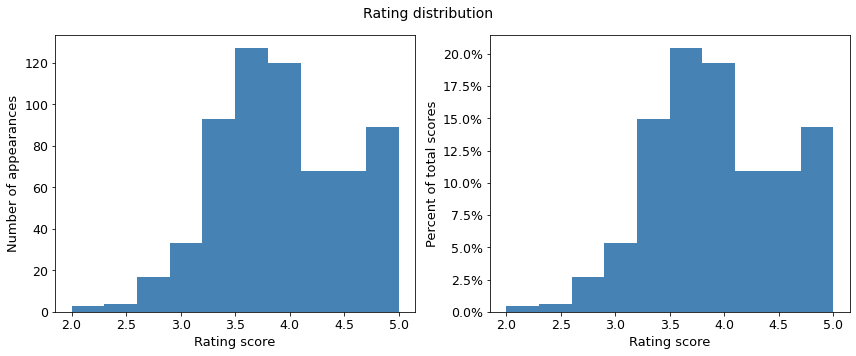

In [11]:
#presenting rating distribution obtained from the data
rating_mask = df['Rating'].notna() #removing NAN from data
rating_list = list(df['Rating'].loc[rating_mask])

fig_rat, ax_rat = plt.subplots(1, 2) #generating subplots
plt.rcParams['figure.figsize'] = [12, 5] #defining a size of a plot
plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) #creating percentage values on y_axis

ax_rat[0].hist(rating_list, color='steelblue') #classic histogram
ax_rat[1].hist(rating_list, weights=np.ones(len(rating_list)) / len(rating_list), color='steelblue') #histogram with percentage on y_axis

#chart formatting
plt.suptitle('Rating distribution',fontsize=14)
ax_rat[0].set_ylabel('Number of appearances', fontsize = 13.0)
ax_rat[0].set_xlabel('Rating score', fontsize = 13.0)
ax_rat[1].set_ylabel('Percent of total scores', fontsize = 13.0)
ax_rat[1].set_xlabel('Rating score', fontsize = 13.0);
ax_rat[0].tick_params(axis='both', labelsize=12.5)
ax_rat[1].tick_params(axis='both', labelsize=12.5)
plt.tight_layout()

rating_mean = mean(rating_list)
rating_len = len(rating_list)
print('The average rating obtained from {} job advertisements was equal {:.2f}'.format(rating_len, rating_mean))

#### Type of ownership

Chart below is in based ten logarithmic scale, the most offer comes from Company - Private and it was 401 job advertisements.
In the dataset was only one advertisement from a hospital


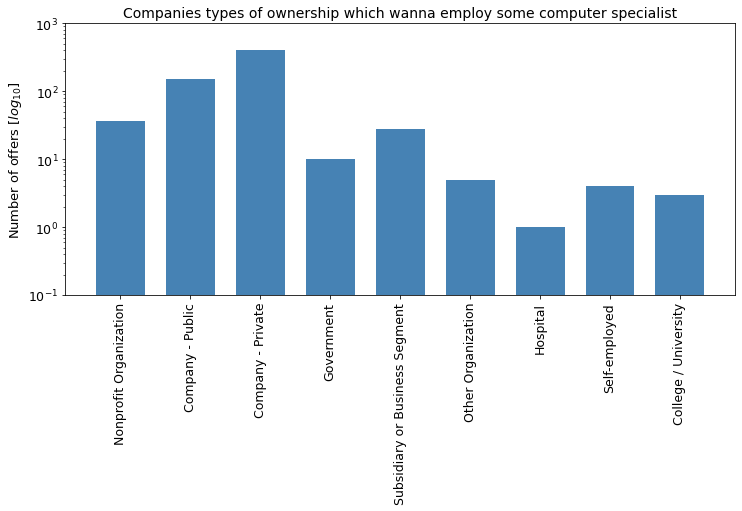

In [12]:
#presenting types of ownership obtained from the data
owner_mask = df['Type_of_Ownership'].notna() #removing NAN from data
owner_list = list(df['Type_of_Ownership'].loc[owner_mask])
owner_dict = dict(Counter(owner_list))

owner_dict_keys = list(owner_dict.keys())
owner_dict_values = list(owner_dict.values())

#chart formatting
fig_own = plt.figure(figsize = (12, 5))
plt.bar(owner_dict_keys, owner_dict_values, color ='steelblue',
        width = 0.7)
plt.title("Companies types of ownership which wanna employ some computer specialist", fontsize = 14.0);
plt.yscale('log')
plt.ylabel('Number of offers [$log_{10}$]', fontsize = 13.0)
plt.xticks(rotation='vertical', fontsize = 12.5)
plt.yticks(fontsize = 12.5);
plt.ylim(0.1, 1000);

#presenting a conculsion
owner_high = Counter(owner_list).most_common(1)[0][0]
owner_high_val = Counter(owner_list).most_common(1)[0][1]
print('Chart below is in based ten logarithmic scale, the most offer comes from {} and it was {} job advertisements.\nIn the dataset was only one advertisement from a hospital'.format(owner_high, owner_high_val))

#### Rating as a function of average salary

There is no visible dependance (now) between rating and average salary in analyzed job adversitements


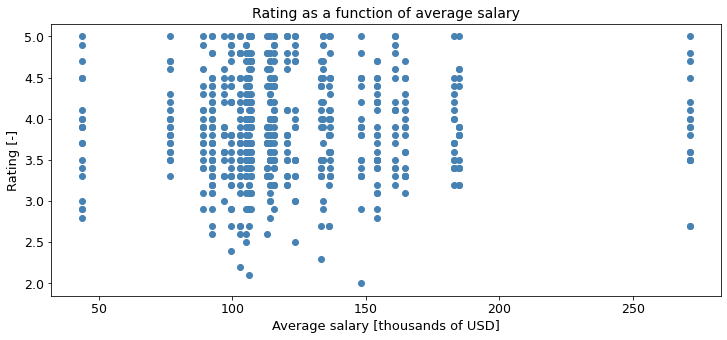

In [13]:
#calculating average salary from each advertisements
salary_range_ave = (pd.to_numeric(df['Salary_Range_Low_Thousands_of_USD']) + pd.to_numeric(df['Salary_Range_High_Thousands_of_USD']))/2
rating = df['Rating'].convert_dtypes()
rat_df = pd.DataFrame({"salary_range_ave": list(salary_range_ave), "rating": list(rating)})
rat_df = rat_df.dropna()

#chart formatting
fig_rat = plt.figure(figsize = (12, 5))
plt.plot( rat_df['salary_range_ave'], rat_df['rating'], "o", color ='steelblue')
plt.title("Rating as a function of average salary", fontsize = 14.0);
plt.ylabel('Rating [-]', fontsize = 13.0)
plt.xlabel('Average salary [thousands of USD]', fontsize = 13.0)
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5);

print('There is no visible dependance (now) between rating and average salary in analyzed job adversitements') #presenting a conculsion

In [17]:
phd_mask

index
0      False
1      False
2       True
3      False
4      False
       ...  
667    False
668    False
669    False
670     True
671    False
Name: Job_Description, Length: 672, dtype: bool